# Randomized Image Sampling for Explanations for Object Dection (D-RISE)

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

In [ ]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)

    def run_on_batch(self, x):
        return self.model.predict(x)

In [ ]:

COLORS = np.random.uniform(0, 255, size=(80, 3))
class Model_yolo():
    def __init__(self):
        self.model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
        self.model.eval()
        self.model.cpu()
        self.input_size = (224, 224)
    def parse_detections(results):
        detections = results.pandas().xyxy[0]
        detections = detections.to_dict()
        boxes, colors, names = [], [], []

        for i in range(len(detections["xmin"])):
            confidence = detections["confidence"][i]
            if confidence < 0.2:
                continue
            xmin = int(detections["xmin"][i])
            ymin = int(detections["ymin"][i])
            xmax = int(detections["xmax"][i])
            ymax = int(detections["ymax"][i])
            name = detections["name"][i]
            category = int(detections["class"][i])
            color = COLORS[category]

            boxes.append((xmin, ymin, xmax, ymax))
            colors.append(color)
            names.append(name)
        return boxes, colors, names


    def run_on_batch(self, x):
        pred_imgs=[]
        for i in range(x.shape[0]):

          results = self.model(x[i])
          df=results.pandas().xyxy[0]
          if df.empty:
            binary_vector=np.zeros(80)
          else:
            binary_vector = np.zeros(80)
            i=0
            for class_value in df['class']:
                binary_vector[class_value] = df.iloc[i]['confidence']
                i+=1

            #print(binary_vector)

          pred_imgs.append(np.array(binary_vector))

        return pred_imgs

### Load and preprocess image

In [ ]:
from keras.preprocessing import image

In [ ]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

---

## RISE

In [ ]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    return masks

In [ ]:
batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    print(type(masked))
    for i in tqdm(range(0, N, batch_size),desc='creating sal'):
        #print(masked[i:min(i+batch_size, N)].shape)
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    #print(preds)
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1
    return sal

---

## Running explanations

In [ ]:
def class_name(idx):
    return decode_predictions(np.eye(1, 80, idx))[0][0][1]

In [ ]:
model = Model_yolo()

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 230.2 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 7.5s, installed 2 packages: ['gitpython>=3.1.30', 'pillow>=10.3.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-5-2 Python-3.10.12 torch-2.2.1+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 38.4MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:

img=cv2.imread('iframe_0095.jpg')
img = cv2.resize(img, (224, 224))
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)



In [ ]:
print(img.shape)

(224, 224, 3)


In [ ]:
print(x.shape)

(1, 224, 224, 3)


In [ ]:
N = 2000
s = 8
p1 = 0.5
masks = generate_masks(2000, 8, 0.5)

Generating masks: 100%|██████████| 2000/2000 [00:04<00:00, 432.23it/s]


In [ ]:
print(masks.shape)

(2000, 224, 224, 1)


In [ ]:
sal = explain(model, x, masks)

<class 'numpy.ndarray'>


creating sal: 100%|██████████| 20/20 [11:27<00:00, 34.39s/it]


In [ ]:
print(sal[2])

[[     0.4794     0.48009      0.4808 ...     0.48139     0.48162     0.48168]
 [    0.47979     0.48048      0.4812 ...     0.48142     0.48166     0.48172]
 [    0.48031       0.481     0.48172 ...     0.48162     0.48186     0.48192]
 ...
 [    0.48766     0.48778     0.48806 ...     0.47151     0.47157     0.47155]
 [    0.48769     0.48784     0.48815 ...     0.47139     0.47146     0.47145]
 [    0.48738     0.48757     0.48793 ...     0.47124     0.47133     0.47134]]


In [ ]:
%matplotlib inline

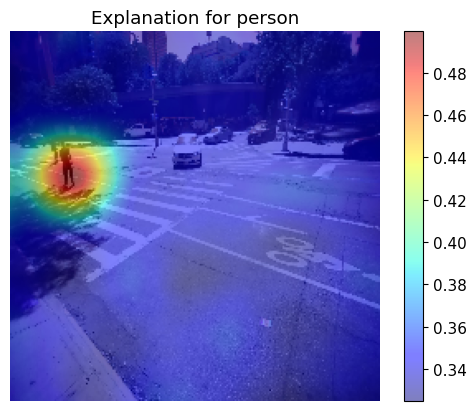

In [ ]:
class_idx = 0
plt.title('Explanation for person')
plt.axis('off')
plt.imshow(img)
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

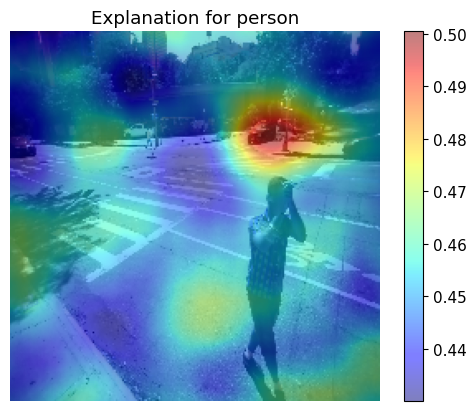

In [ ]:
class_idx = 2
plt.title('Explanation for person')
plt.axis('off')
plt.imshow(img)
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

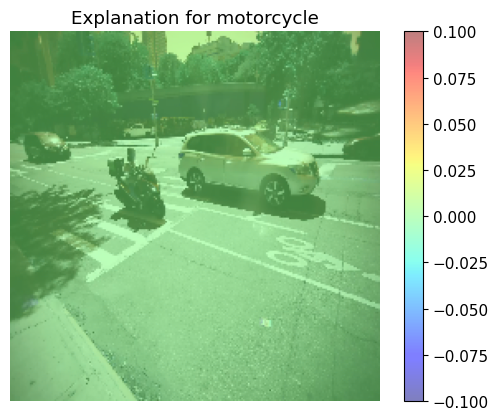

In [ ]:
class_idx = 3
plt.title('Explanation for motorcycle')
plt.axis('off')
plt.imshow(img)
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

In [ ]:
results = model.model([img])
print(results.pandas().xyxy[0])

        xmin        ymin        xmax        ymax  confidence  class  \
0   7.425616   61.259834   37.273983   82.827858    0.862429      2   
1  52.455635   63.636604   73.093674   75.970055    0.816763      2   
2  76.923546   19.113317  210.563965  103.312309    0.788504      7   
3   0.840185  156.989792   77.563858  224.000000    0.436435     37   
4  80.077133   20.017529   86.383049   29.201172    0.320712      9   

            name  
0            car  
1            car  
2          truck  
3      surfboard  
4  traffic light  


In [ ]:
def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img